In [1]:
# Parameters
animal = "103-21"
col_names = ["time", "g1", "g2", "g3", "g4", "du1", "du2"]
chan_to_keep = ["time", "g1", "g2", "g3", "g4"]
new_sample_freq = 200
original_sample_freq = 2000
filter_type = "bandpass"
lo_cutoff = 0.05
hi_cutoff = 0.7
use_dropped_packet_removal = True
use_artifact_removal = True
pre_post_pts = 10
fill_frontend = True


# Load modules

In [2]:
# load modules
from rich import print
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from directory_structure import Tree
import sys, os
import os.path as path
import glob
import re
import pickle

modules = path.abspath(path.join(os.getcwd(), "helpers"))
print(modules)
sys.path.insert(0, modules)

from import_files import *
from preprocessing import *
from plotting import *

%matplotlib inline

/home/github_repos/PITT_NN_paper/1_preprocessing/helpers

# Load data, rename columns, save/load to pickles to increase speed (and remove channels)

In [3]:
# get list of files and pickles
####################################

file_lst = glob.glob("Data/" + animal + "/*.txt")
print(file_lst)

pickle_lst = glob.glob("pickles/" + animal + "*.pckl")
print(pickle_lst)

# make df names
####################################

df_name_lst = []
for x in file_lst:
    if 'eed' in x:
        df_name_lst.append('df_feed')
    if 'ase' in x:
        df_name_lst.append('df_base')

# load pickles or make pickles
####################################

if len(file_lst) == len(pickle_lst):
    print("import pickles")
    for x, y in zip(pickle_lst, df_name_lst):
        print(y)
        df_x = Import.open_pickle(x)
        exec(y + " = df_x")
        print()
else:
    print("import CSVs and make pickles")
    for x, y in zip(file_lst, df_name_lst):
        print(y)
        df_x = Import.csv_import_to_pandas(file_path=x, df_name=y, print_df=False)
        df_x.columns = col_names
        # drop channel
        df_x = df_x[chan_to_keep]
        print(df_x)
        # store pickle
        # create directory if it does not exist
        file_path = 'pickles/'
        if not os.path.exists(file_path):
            os.mkdir(file_path)
        Import.store_pickle(obj=df_x, file_path='pickles/' + animal + '_' + y +'.pckl')
        exec(y + " = df_x")
        print()

['Data/103-21/103-21_Feeding_10-20-21.txt', 'Data/103-21/103-21_Baseline_10-18-21.txt']

['pickles/103-21_df_base.pckl', 'pickles/103-21_df_feed.pckl']

import pickles

df_feed

time            g1            g2            g3            g4
0           0.0000  31903.246094 -73771.679688 -20229.501953 -27639.638672
1           0.0005  31875.347656 -73753.546875 -20235.666016 -27640.898438
2           0.0010  31882.062500 -73756.039063 -20238.060547 -27648.359375
3           0.0015  31905.371094 -73790.015625 -20236.052734 -27652.464844
4           0.0020  31907.597656 -73805.664063 -20231.498047 -27656.003906
...            ...           ...           ...           ...           ...
7200035  3600.0175  48130.558594 -62345.882813 -33946.218750 -55429.062500
7200036  3600.0180  48105.570313 -62332.039063 -33904.539063 -55394.941406
7200037  3600.0185  48079.000000 -62320.015625 -33884.394531 -55359.386719
7200038  3600.0190  48076.906250 -62328.695313 -33900.183594 -55366.910156
7200039  3600.0195  48072.851563 -62364.453125 -33906.511719 -55394.757813

[7200040 rows x 5 columns]

df_base

time            g1            g2            g3            g4
0           0.0000  35549.394531 -53654.718750 -16029.708984 -56655.714844
1           0.0005  35560.648438 -53648.976563 -16024.414063 -56655.011719
2           0.0010  35563.941406 -53647.007813 -16023.587891 -56658.511719
3           0.0015  35550.589844 -53650.882813 -16029.537109 -56662.171875
4           0.0020  35517.316406 -53667.089844 -16041.707031 -56665.714844
...            ...           ...           ...           ...           ...
7200039  3600.0195  41229.445313 -62636.003906 -37998.179688 -57362.933594
7200040  3600.0200  41199.546875 -62653.144531 -38012.703125 -57376.203125
7200041  3600.0205  41185.382813 -62664.601563 -38022.187500 -57383.777344
7200042  3600.0210  41180.597656 -62668.410156 -38028.750000 -57387.652344
7200043  3600.0215  41195.074219 -62664.019531 -38027.062500 -57392.109375

[7200044 rows x 5 columns]

## Determine percentage missing values

In [4]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Downsample after applying anti-aliasing filter

In [5]:
factor = int(original_sample_freq / new_sample_freq)
print(factor)

for x in df_name_lst:

    df1 = locals()[x]

    # get df with time values
    df_x = df1.iloc[::factor, :].time
    df_x.reset_index(drop=True, inplace=True)
    df_x = pd.DataFrame(df_x)

    for y in chan_to_keep[1:]:    
        arr = Preprocessing.downsample_with_anti_aliasing(arr=df1[y], factor=factor, ftype='iir')
        df_x[y] = arr.tolist()

    exec(x + " = df_x")
    print(df_x)

10

Original length = 7200040
New length = 720004
Original length = 7200040


New length = 720004
Original length = 7200040
New length = 720004
Original length = 7200040


New length = 720004


time            g1            g2            g3            g4
0          0.000  31539.520722 -72929.623277 -19999.973083 -27322.550435
1          0.005  31508.384007 -72900.589106 -19980.470999 -27328.070961
2          0.010  31487.971279 -72903.199791 -20005.031366 -27290.789595
3          0.015  31498.801165 -72921.523476 -20052.813181 -27307.146302
4          0.020  31527.915135 -72915.128963 -20078.675413 -27361.045578
...          ...           ...           ...           ...           ...
719999  3599.995  47395.051306 -61546.144318 -33487.494192 -54712.435341
720000  3600.000  47513.774464 -61576.930386 -33491.993593 -54727.186947
720001  3600.005  47419.339533 -61605.495190 -33508.810673 -54719.052275
720002  3600.010  47376.080894 -61619.387339 -33513.087836 -54651.857656
720003  3600.015  47480.099327 -61631.025230 -33509.537276 -54675.962729

[720004 rows x 5 columns]

Original length = 7200044
New length = 720005
Original length = 7200044


New length = 720005
Original length = 7200044
New length = 720005
Original length = 7200044


New length = 720005


time            g1            g2            g3            g4
0          0.000  35142.403586 -53040.062602 -15846.341289 -56007.328616
1          0.005  35137.982215 -53048.115012 -15851.220488 -56017.878845
2          0.010  35129.517868 -53055.700660 -15843.970028 -56009.261090
3          0.015  35116.730437 -53070.437019 -15845.479764 -56003.090875
4          0.020  35121.320054 -53078.461301 -15844.559241 -56007.626960
...          ...           ...           ...           ...           ...
720000  3600.000  40735.979824 -61934.854927 -37567.540957 -56734.998309
720001  3600.005  40741.225488 -61938.928199 -37573.724367 -56740.749870
720002  3600.010  40754.219632 -61934.291238 -37572.965076 -56753.888150
720003  3600.015  40747.394973 -61931.308558 -37571.658435 -56739.350867
720004  3600.020  40729.527366 -61941.483296 -37584.976240 -56730.339791

[720005 rows x 5 columns]

## Determine percentage missing values

In [6]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Remove dropped packets (errors in the hardware recording)

In [7]:
if use_dropped_packet_removal:
    
    df_packet_drop = pd.DataFrame()
    
    removed_pct_lst = []
    cond_lst = []
    chan_lst = []

    for x in df_name_lst:
 
        df_x = locals()[x]
        
        for y in chan_to_keep[1:]:

            df_x[y], removed_pct = Preprocessing.remove_dropped_packets_zerofill(arr=df_x[y], thres=100000)
            removed_pct_lst.append(removed_pct)
            cond_lst.append(x)
            chan_lst.append(y)
            
        exec(x + ' = df_x')
 
    df_packet_drop['cond'] = cond_lst
    df_packet_drop['chan'] = chan_lst
    df_packet_drop['removed_pct'] = removed_pct_lst
    
    print(df_packet_drop)

cond chan  removed_pct
0  df_feed   g1          0.0
1  df_feed   g2          0.0
2  df_feed   g3          0.0
3  df_feed   g4          0.0
4  df_base   g1          0.0
5  df_base   g2          0.0
6  df_base   g3          0.0
7  df_base   g4          0.0

## Determine percentage missing values

In [8]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Plot raw signals

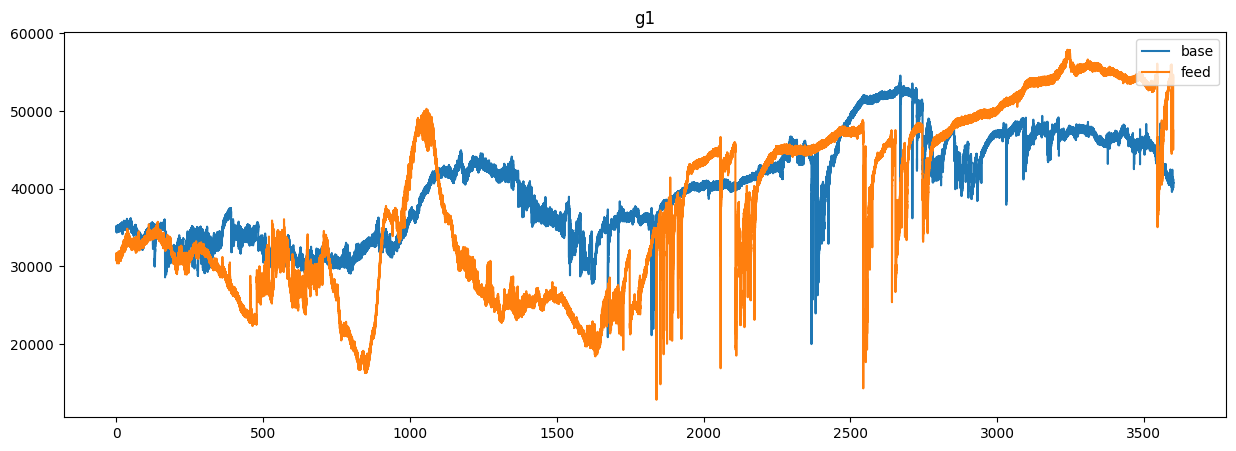

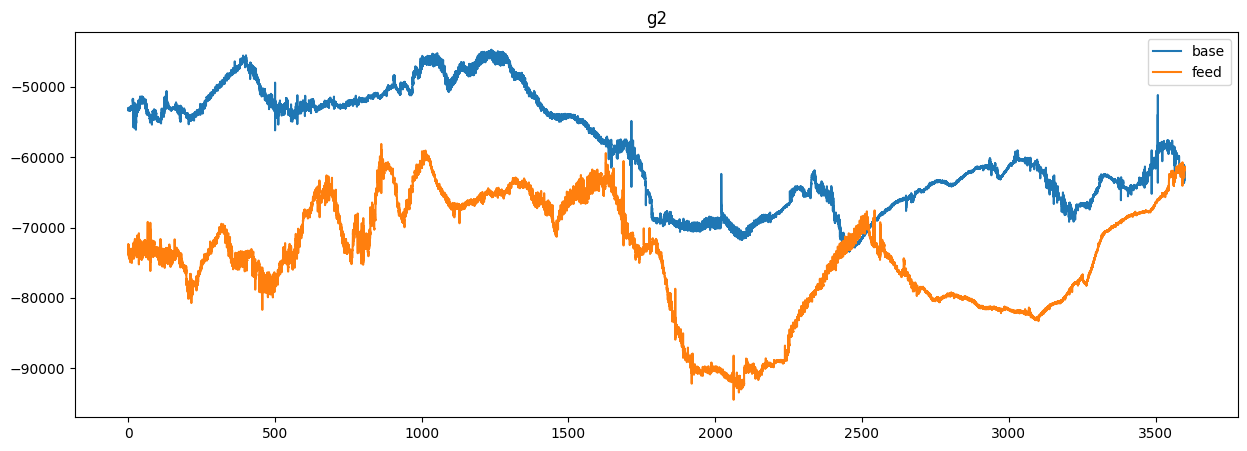

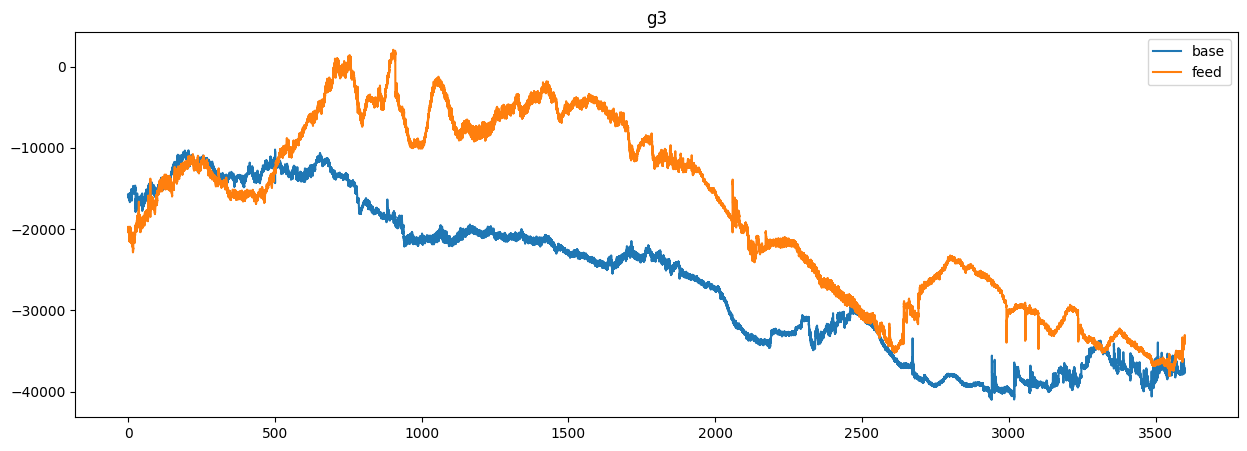

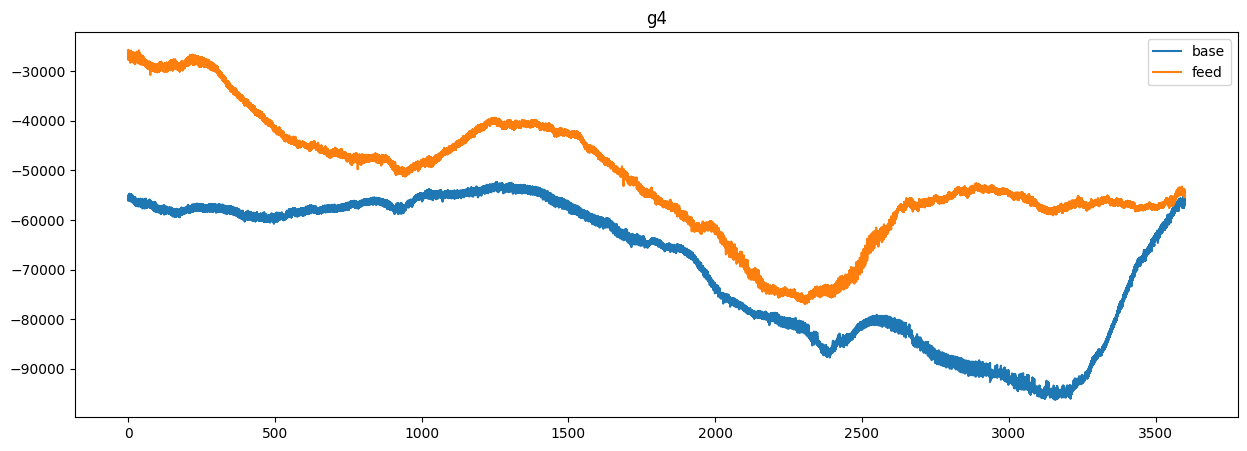

In [9]:
for x in chan_to_keep[1:]:
    plt.figure(figsize=(15,5))
    plt.title(x)
    plt.plot(df_base['time'], df_base[x], label='base')
    plt.plot(df_feed['time'], df_feed[x], label='feed')
    plt.legend(loc='upper right')

# Apply filters

## If band pass

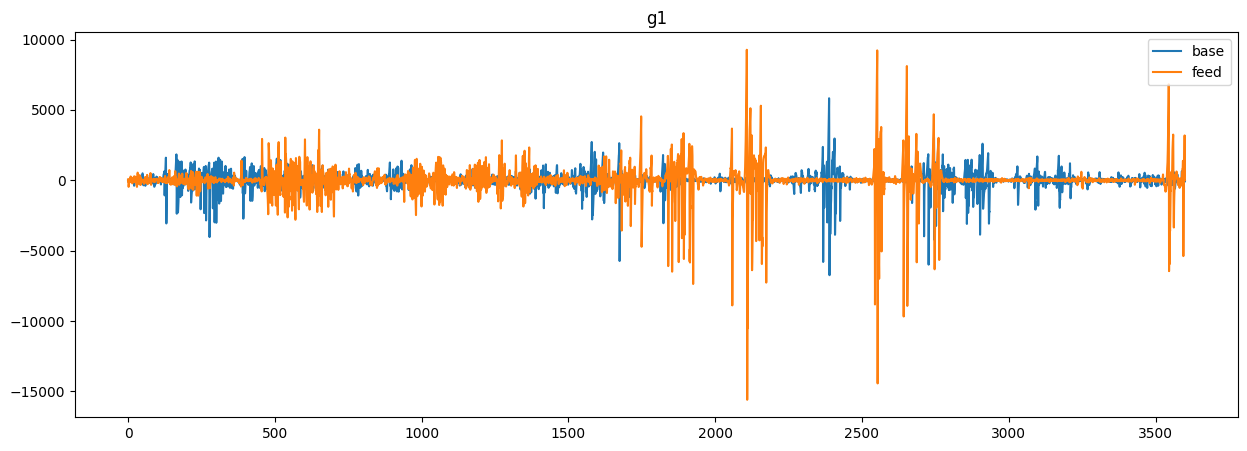

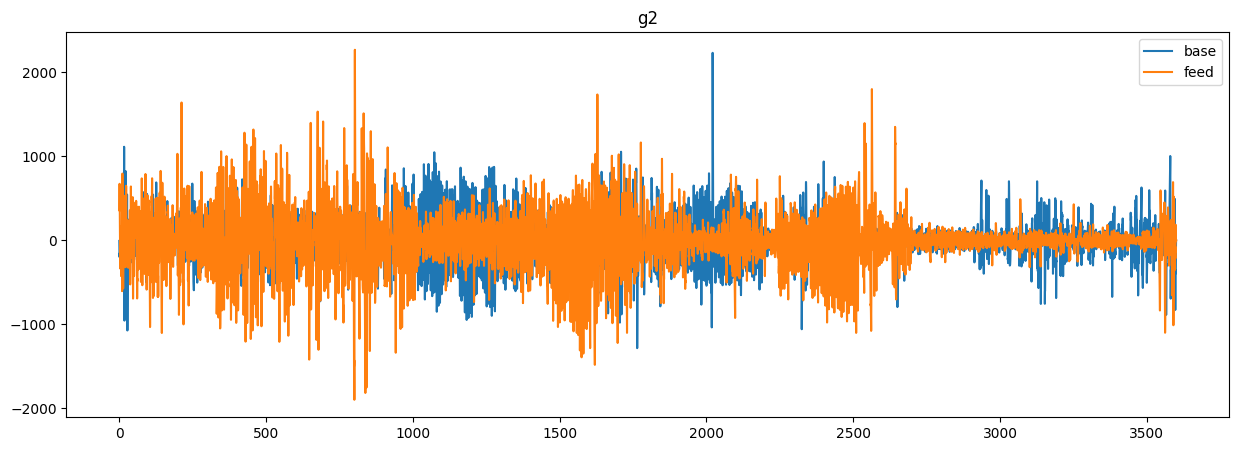

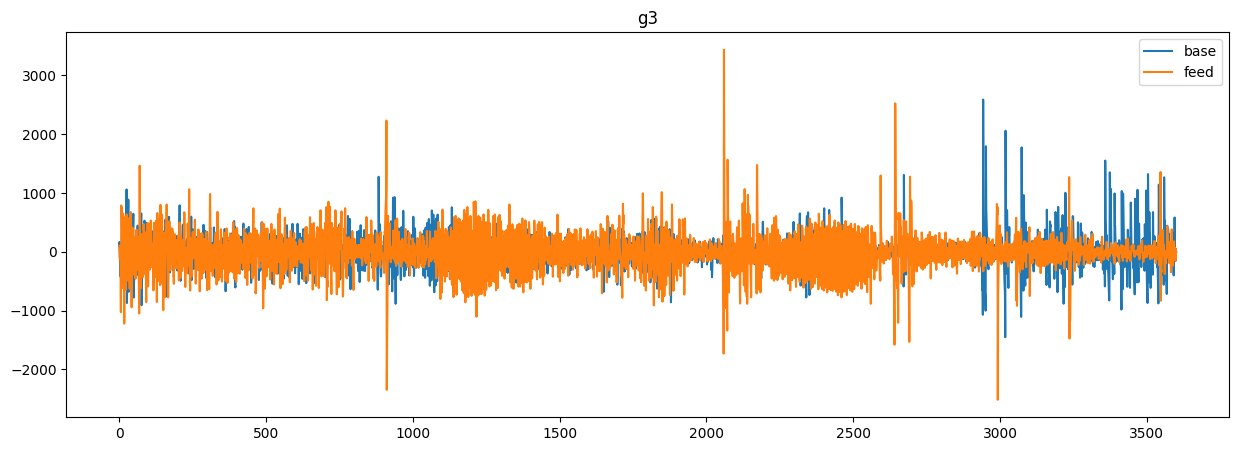

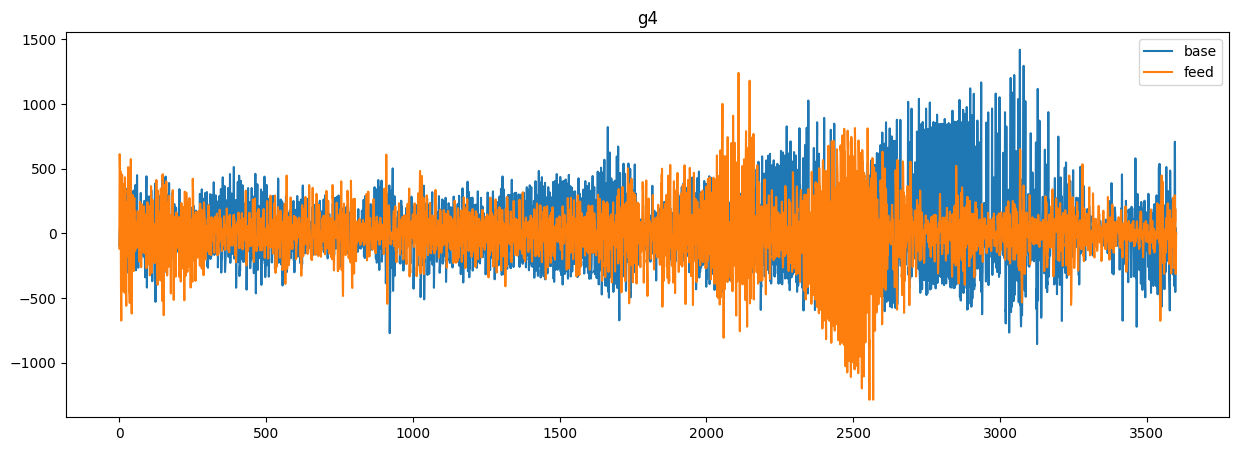

In [10]:
if filter_type == 'bandpass':
    
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.bandpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, 
                                                           lowcut=lo_cutoff, highcut=hi_cutoff)
        exec(x + ' = df_x')

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## If high pass

In [11]:
if (filter_type == 'butter_high_low') or (filter_type == 'butter_high_savgol_low') or (filter_type == 'butter_high_only'):
    
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.highpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, cutoff_freq=lo_cutoff)
        exec(x + ' = df_x')

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## If low pass

In [12]:
if filter_type == 'butter_high_low':
        
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.lowpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, 
                                                           cutoff_freq=hi_cutoff)
        exec(x + ' = df_x')
        
    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

if filter_type == 'butter_high_savgol_low':
            
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            arr = Preprocessing.savitzky_golay_filter(arr=df_x[y].values, win_len=sg_len, order=sg_order)
            df_x[y] = pd.Series(arr)
        exec(x + ' = df_x')

    for x in col_names[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## Determine percentage missing values

In [13]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Artifact removal > 2 mV

w/ Linear interpolation
w/ backfill on front end
Percentage removed: 4.54 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.02 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.12 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.0 %


time         g1          g2          g3          g4
0          0.000  62.077647  359.237219  100.171323 -117.702316
1          0.005  58.914228  361.826079   98.710702 -114.167808
2          0.010  55.769134  364.418849   97.256494 -110.647037
3          0.015  52.643416  367.014894   95.809394 -107.140822
4          0.020  49.538089  369.613578   94.370089 -103.649933
...          ...        ...         ...         ...         ...
719999  3599.995  23.740846    0.112904    0.627082   -1.304808
720000  3600.000  20.300234    0.107483    0.544735   -1.115962
720001  3600.005  17.197328    0.100529    0.468729   -0.945295
720002  3600.010  14.417506    0.092392    0.399070   -0.792108
720003  3600.015  11.945625    0.083410    0.335729   -0.655670

[720004 rows x 5 columns]

w/ Linear interpolation
w/ backfill on front end
Percentage removed: 1.44 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.02 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.03 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.0 %


time         g1         g2         g3         g4
0          0.000 -29.243052  -6.133995  92.286490 -92.256445
1          0.005 -30.173968  -8.843902  92.711293 -91.812013
2          0.010 -31.105003 -11.552635  93.140390 -91.360224
3          0.015 -32.035756 -14.259194  93.573757 -90.901178
4          0.020 -32.965821 -16.962577  94.011369 -90.434986
...          ...        ...        ...        ...        ...
720000  3600.000   0.613407  -0.624861   0.513644   0.281924
720001  3600.005   0.524003  -0.535749   0.441499   0.242758
720002  3600.010   0.443475  -0.455090   0.375984   0.207098
720003  3600.015   0.371421  -0.382570   0.316877   0.174846
720004  3600.020   0.307426  -0.317853   0.263944   0.145894

[720005 rows x 5 columns]

cond chan  removed_pct
0  df_feed   g1         4.54
1  df_feed   g2         0.02
2  df_feed   g3         0.12
3  df_feed   g4         0.00
4  df_base   g1         1.44
5  df_base   g2         0.02
6  df_base   g3         0.03
7  df_base   g4         0.00

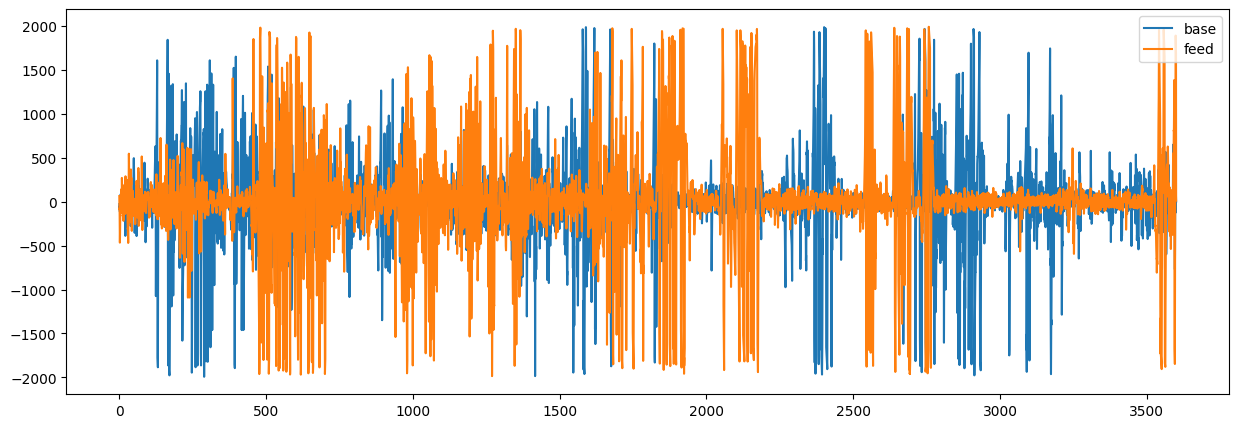

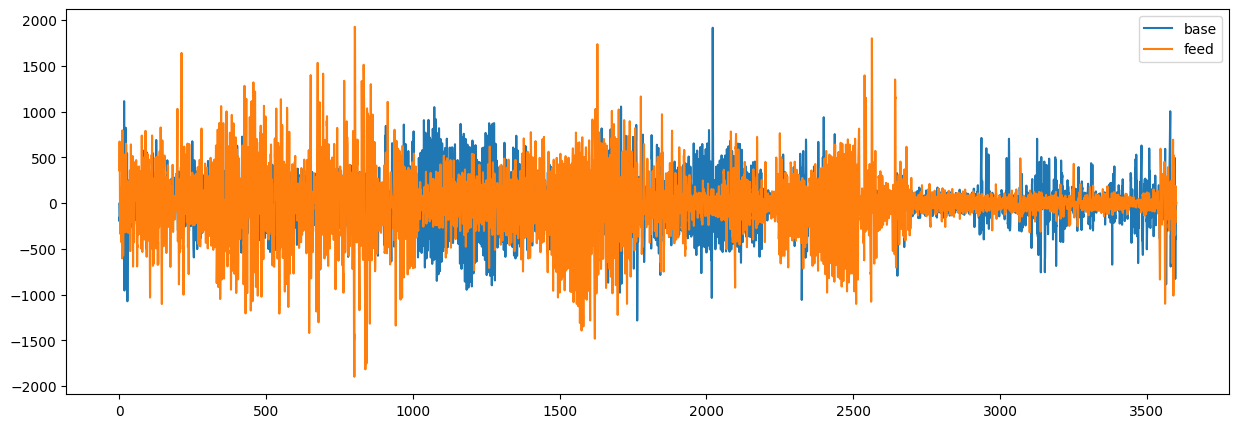

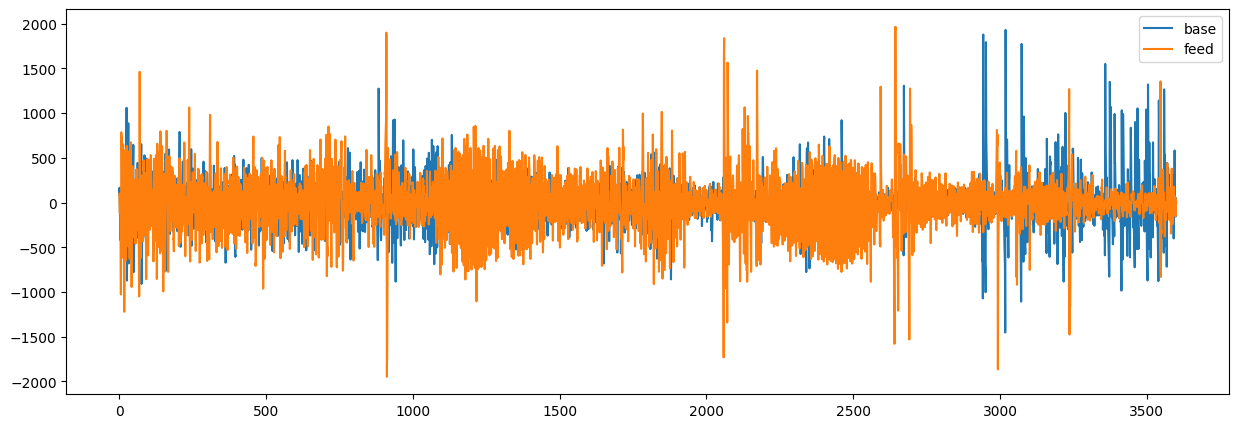

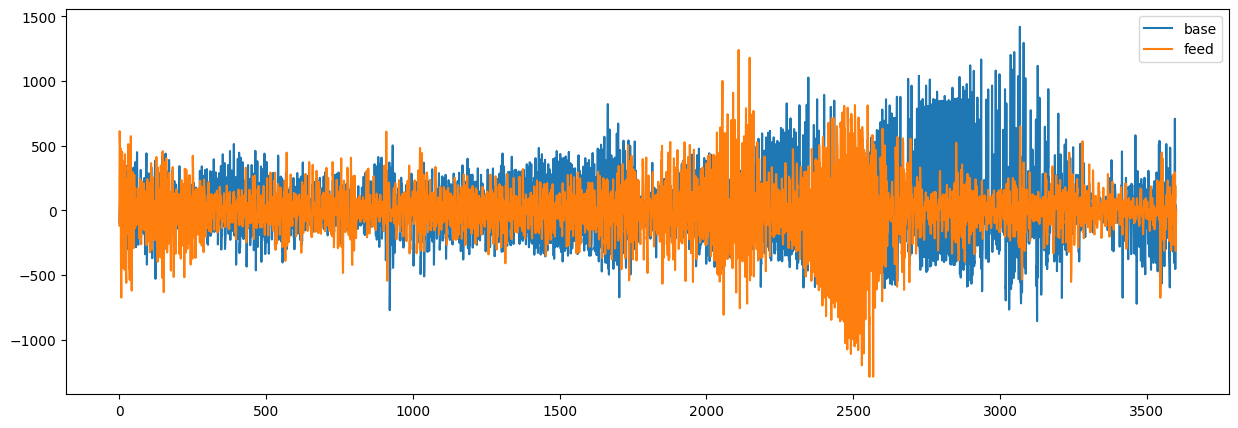

In [14]:
if use_artifact_removal:
    
    df_artifact_remove = pd.DataFrame()
    
    removed_pct_lst = []
    cond_lst = []
    chan_lst = []

    for x in df_name_lst:
 
        df_x = locals()[x]
        
        for y in chan_to_keep[1:]:
            
            # apply filter
            df_x[y], removed_pct = Preprocessing.artifacts_removal(arr=df_x[y], thres=2000, 
                                                                   pts_pre=pre_post_pts, 
                                                                   pts_post=pre_post_pts, 
                                                                   interpolate=True,
                                                                   fill_frontend=fill_frontend)
            removed_pct_lst.append(removed_pct)
            cond_lst.append(x)
            chan_lst.append(y)
        print(df_x)   
        exec(x + ' = df_x')
 
    df_artifact_remove['cond'] = cond_lst
    df_artifact_remove['chan'] = chan_lst
    df_artifact_remove['removed_pct'] = removed_pct_lst
    
    print(df_artifact_remove)

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## Determine percentage missing values

In [15]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Plots: power spectral density (from 3 to 15 cpm)

df_feed

Total power = 568385937.8458807 Dom freq = 0.056110799384447865

Bradygastric power = 348252170.8379028 Dom freq = 0.056110799384447865

normygastric power = 150727281.46309206 Dom freq = 0.16333242593096706

tachygastric power = 69406485.54488592 Dom freq = 0.19611002161099106

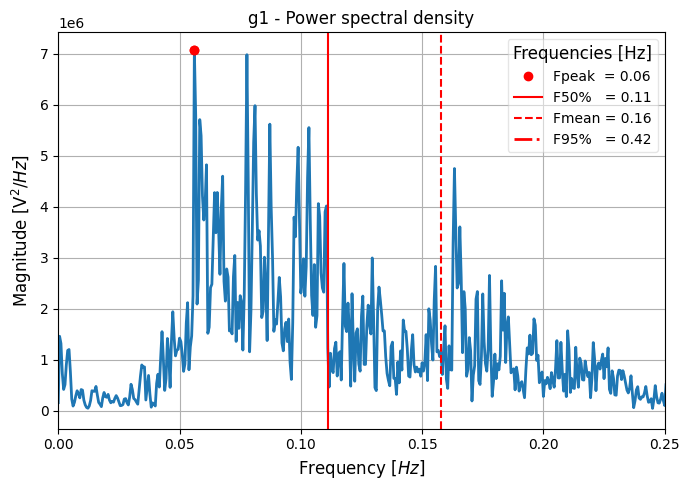

Total power = 197778010.42941213 Dom freq = 0.16166576852350822

Bradygastric power = 45931157.61398919 Dom freq = 0.08888839506447187

normygastric power = 130795862.56031318 Dom freq = 0.16166576852350822

tachygastric power = 21050990.255109765 Dom freq = 0.19111004938861453

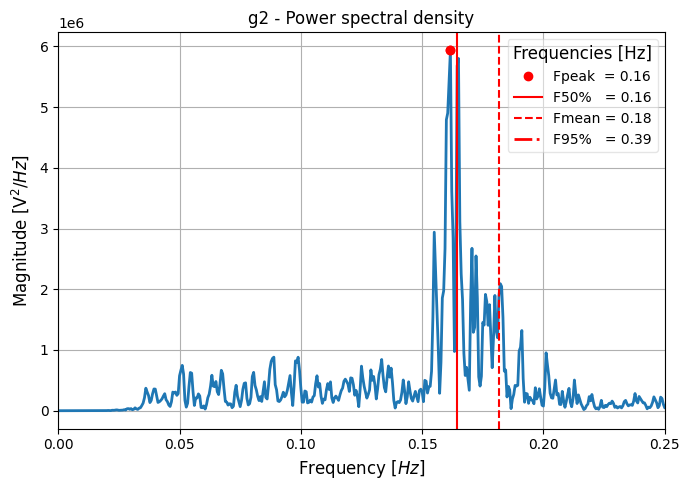

Total power = 143850323.9361387 Dom freq = 0.16222132099266118

Bradygastric power = 48264917.69341523 Dom freq = 0.06166632407597736

normygastric power = 78251074.66002847 Dom freq = 0.16222132099266118

tachygastric power = 17334331.58269501 Dom freq = 0.20222109877167352

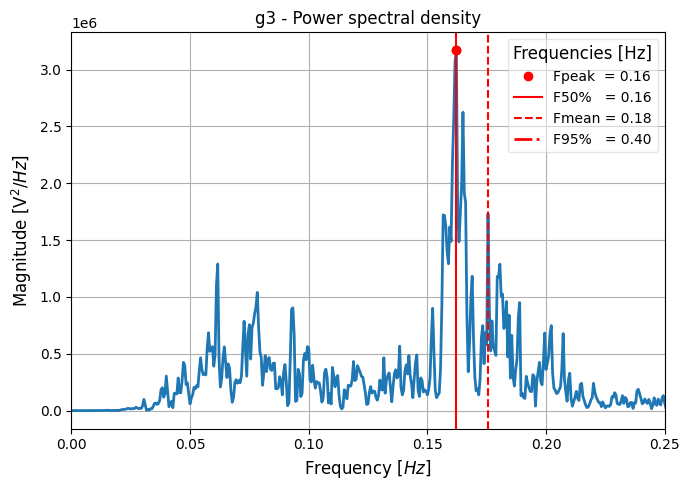

Total power = 73566288.37200472 Dom freq = 0.16111021605435527

Bradygastric power = 18266818.599657357 Dom freq = 0.09166615741023662

normygastric power = 50772917.48241111 Dom freq = 0.16111021605435527

tachygastric power = 4526552.289936248 Dom freq = 0.23888756173576814

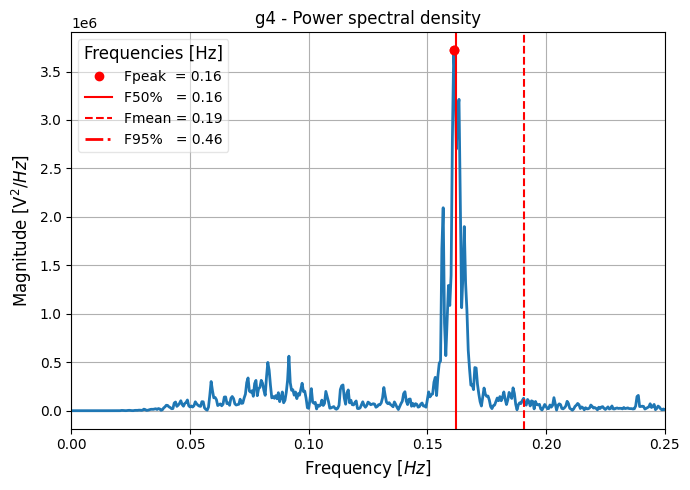

df_base

Total power = 203398721.5917387 Dom freq = 0.1605542176037422

Bradygastric power = 110602184.69788763 Dom freq = 0.0766660277831018

normygastric power = 68147143.64441341 Dom freq = 0.1605542176037422

tachygastric power = 24649393.24943767 Dom freq = 0.19277617130968352

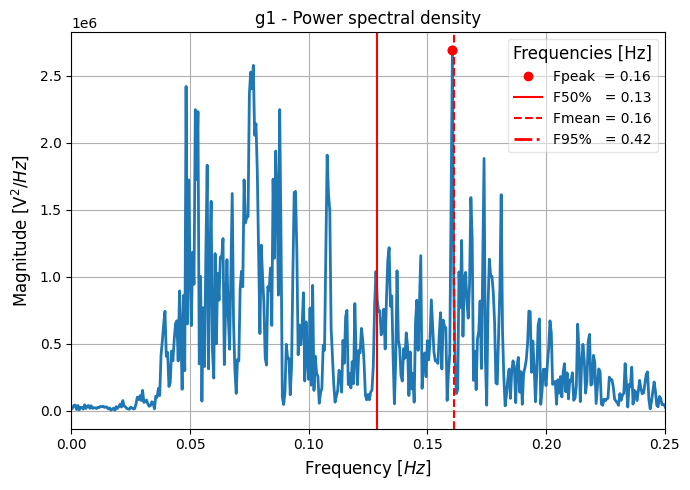

Total power = 147126707.7550556 Dom freq = 0.17499854167881934

Bradygastric power = 21023365.74839414 Dom freq = 0.08777704630239193

normygastric power = 92054228.52003372 Dom freq = 0.17499854167881934

tachygastric power = 34049113.48662775 Dom freq = 0.19333172223564804

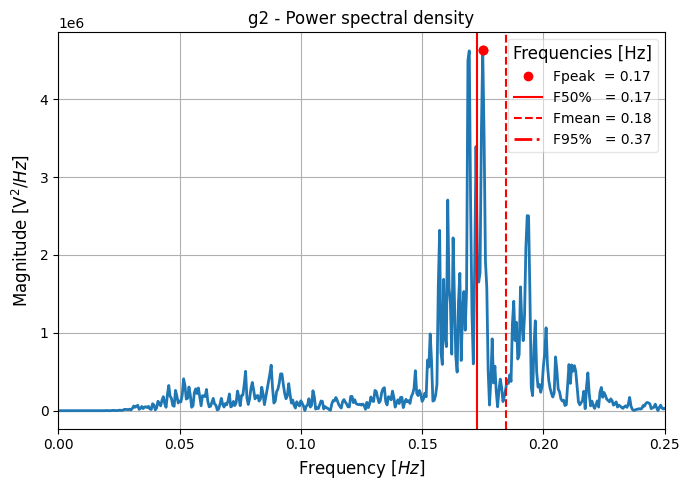

Total power = 63965456.80070838 Dom freq = 0.1627764213076002

Bradygastric power = 17199771.736828078 Dom freq = 0.06555500926381169

normygastric power = 35099804.01616866 Dom freq = 0.1627764213076002

tachygastric power = 11665881.047711637 Dom freq = 0.19277617130968352

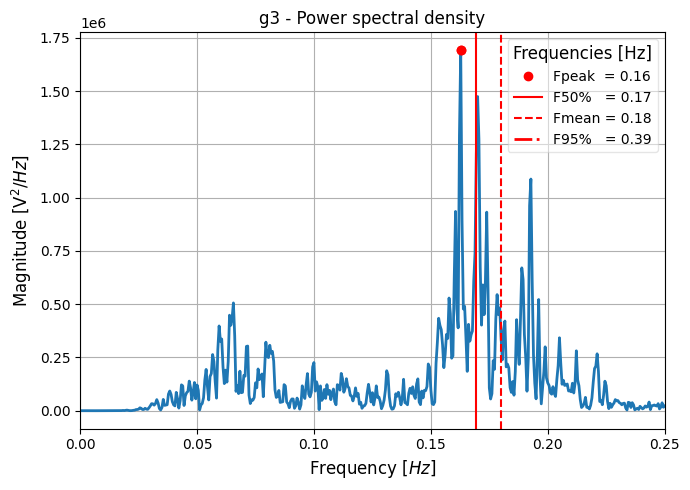

Total power = 48880210.67716446 Dom freq = 0.17333188890092582

Bradygastric power = 10943115.840954375 Dom freq = 0.08277708796871137

normygastric power = 32750206.34804675 Dom freq = 0.17333188890092582

tachygastric power = 5186888.4881633315 Dom freq = 0.19277617130968352

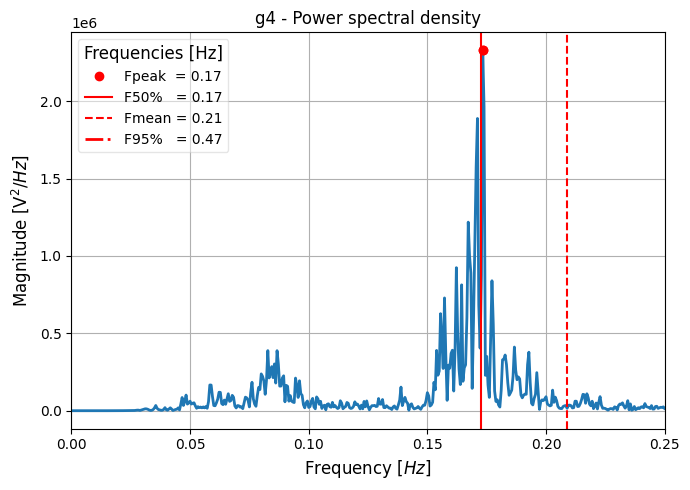

cond chan     tot_power    brad_power    norm_power    tach_power  \
0  df_feed   g1  5.683859e+08  3.482522e+08  1.507273e+08  6.940649e+07   
0  df_feed   g2  1.977780e+08  4.593116e+07  1.307959e+08  2.105099e+07   
0  df_feed   g3  1.438503e+08  4.826492e+07  7.825107e+07  1.733433e+07   
0  df_feed   g4  7.356629e+07  1.826682e+07  5.077292e+07  4.526552e+06   
0  df_base   g1  2.033987e+08  1.106022e+08  6.814714e+07  2.464939e+07   
0  df_base   g2  1.471267e+08  2.102337e+07  9.205423e+07  3.404911e+07   
0  df_base   g3  6.396546e+07  1.719977e+07  3.509980e+07  1.166588e+07   
0  df_base   g4  4.888021e+07  1.094312e+07  3.275021e+07  5.186888e+06   

   brad_domf  norm_domf  tach_domf  
0     0.0561     0.1633     0.1961  
0     0.0889     0.1617     0.1911  
0     0.0617     0.1622     0.2022  
0     0.0917     0.1611     0.2389  
0     0.0767     0.1606     0.1928  
0     0.0878     0.1750     0.1933  
0     0.0656     0.1628     0.1928  
0     0.0828     0.1733     0.1928

#########################################################

In [16]:
df_summary = pd.DataFrame()

for x in df_name_lst:
    
    print(x)

    df_x = locals()[x]
    
    for y in chan_to_keep[1:]:
        df_final = Plotting.psd(df_x[y], fs=new_sample_freq, xlim=[0,0.25], units='V', title=y, 
                                tot_pwr_lst=[0.05, 0.25], brad_pwr_lst=[0.05, 0.127], norm_pwr_lst=[0.127, 0.19], tach_pwr_lst=[0.19, 0.25])
        df_final['cond'] = x
        df_final['chan'] = y
        df_summary = pd.concat([df_summary, df_final])
    exec(x + '_summary = df_summary')

# change the order of columns and drop a column
df_summary = df_summary[['cond', 'chan', 'tot_power', 'brad_power', 'norm_power', 'tach_power', 'brad_domf', 'norm_domf', 'tach_domf']]
    
print(df_summary)

print('#########################################################')
print()

# Plot spectrograms

df_feed

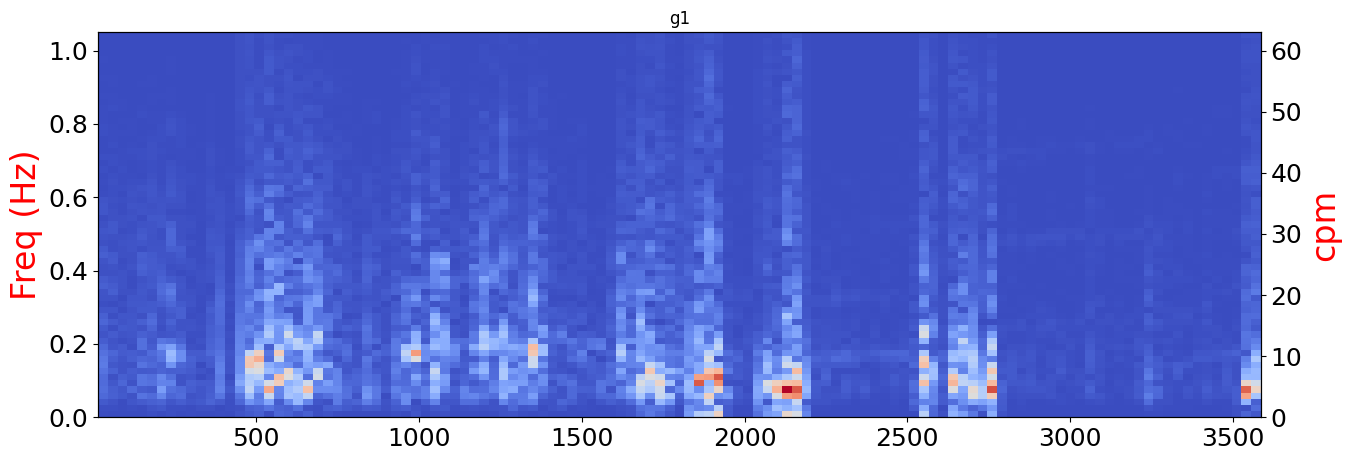

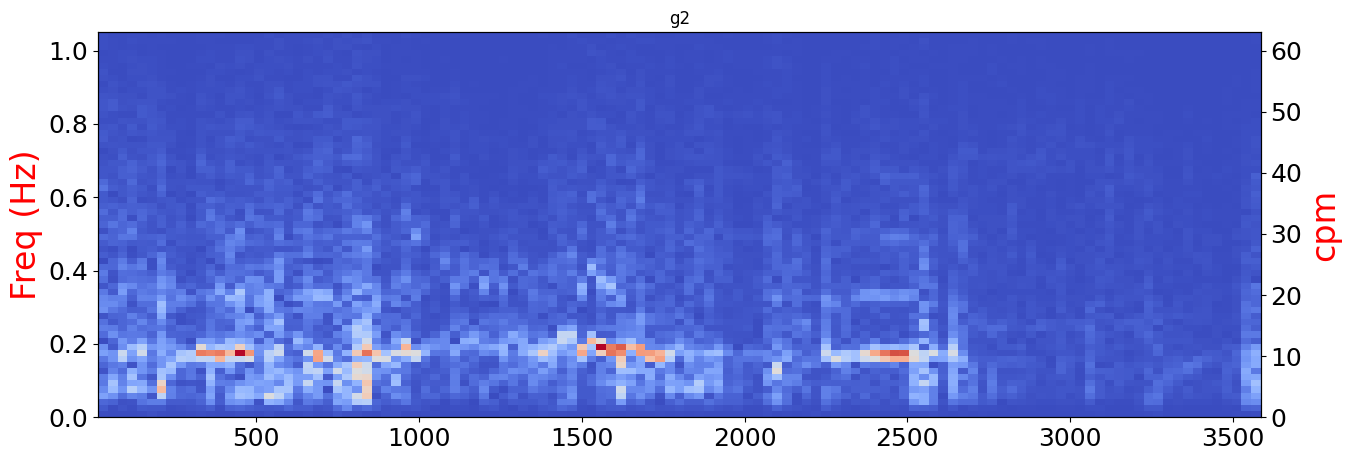

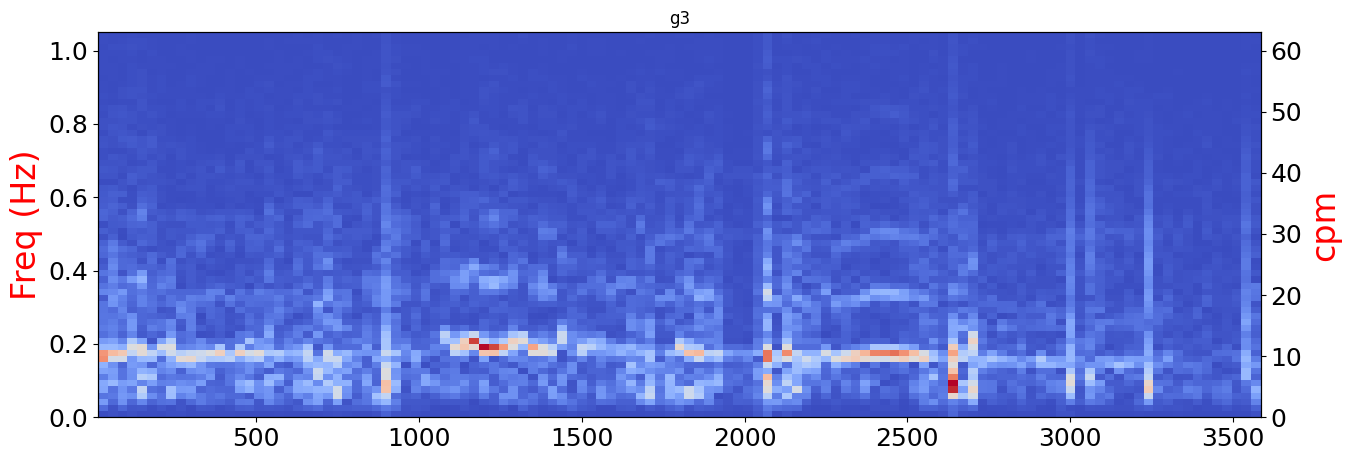

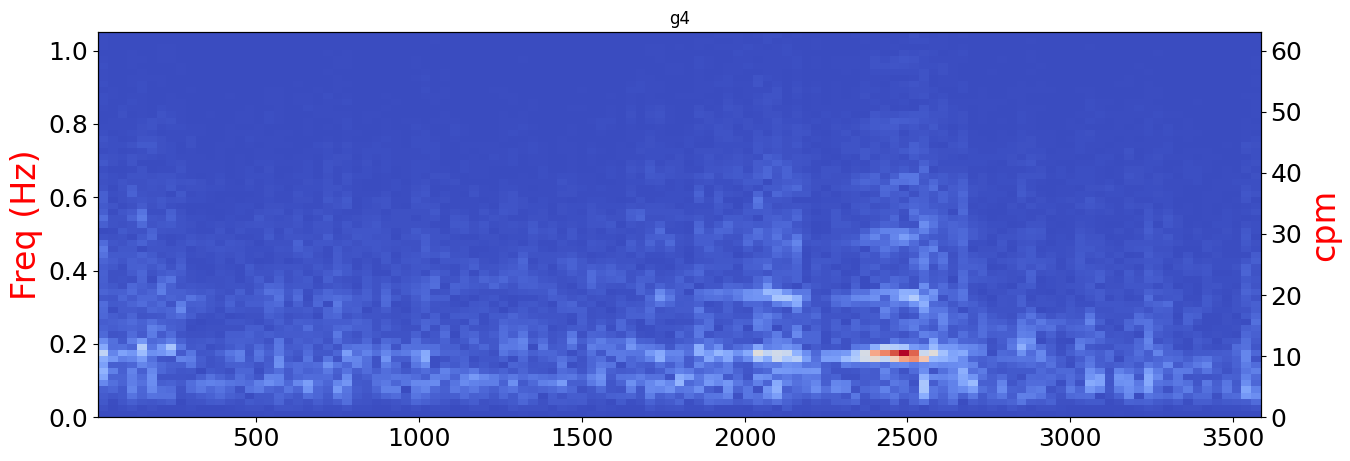

#########################################################

df_base

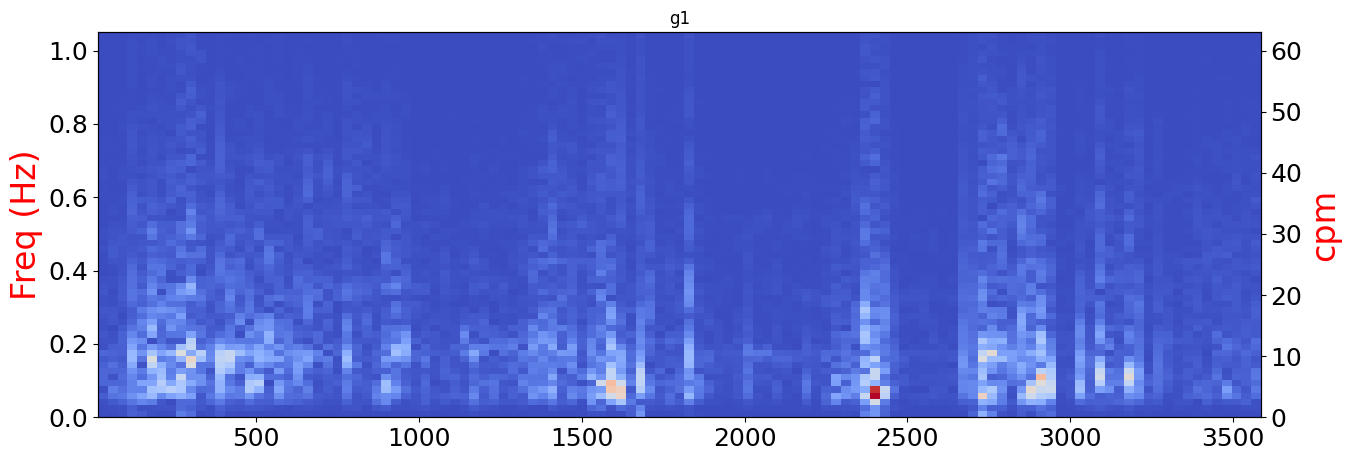

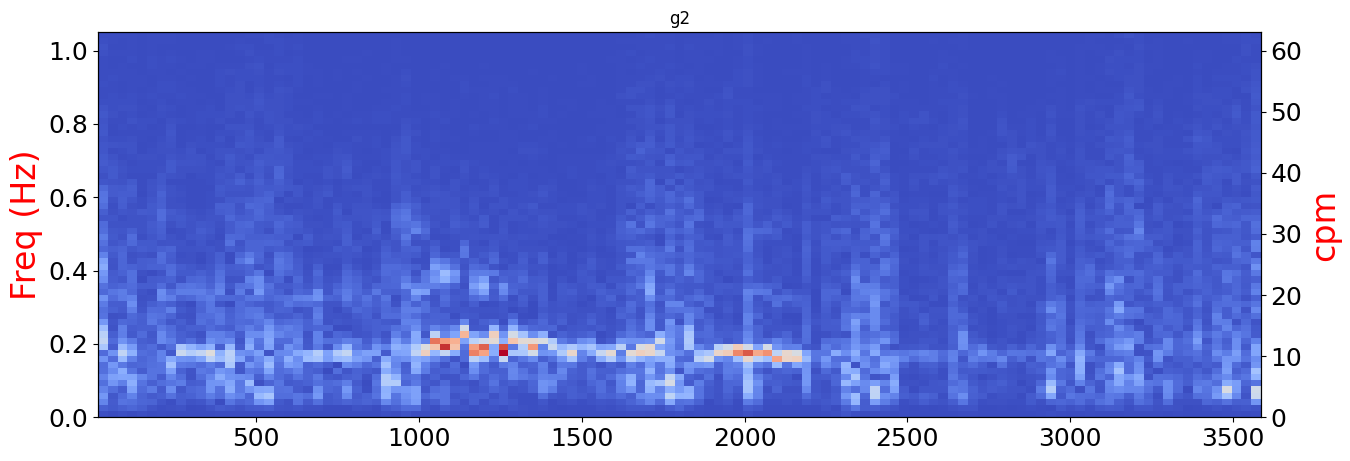

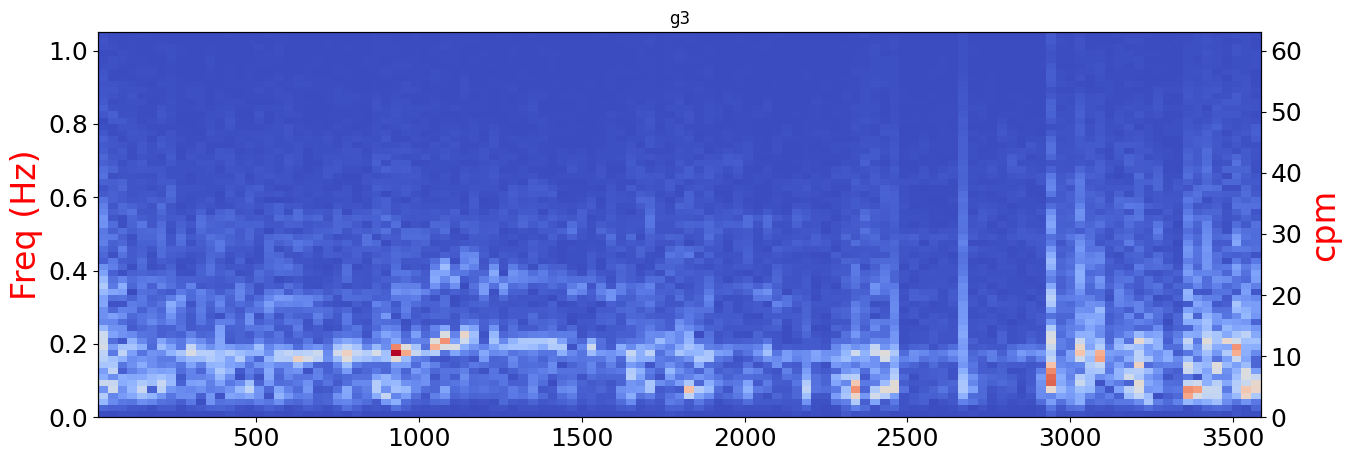

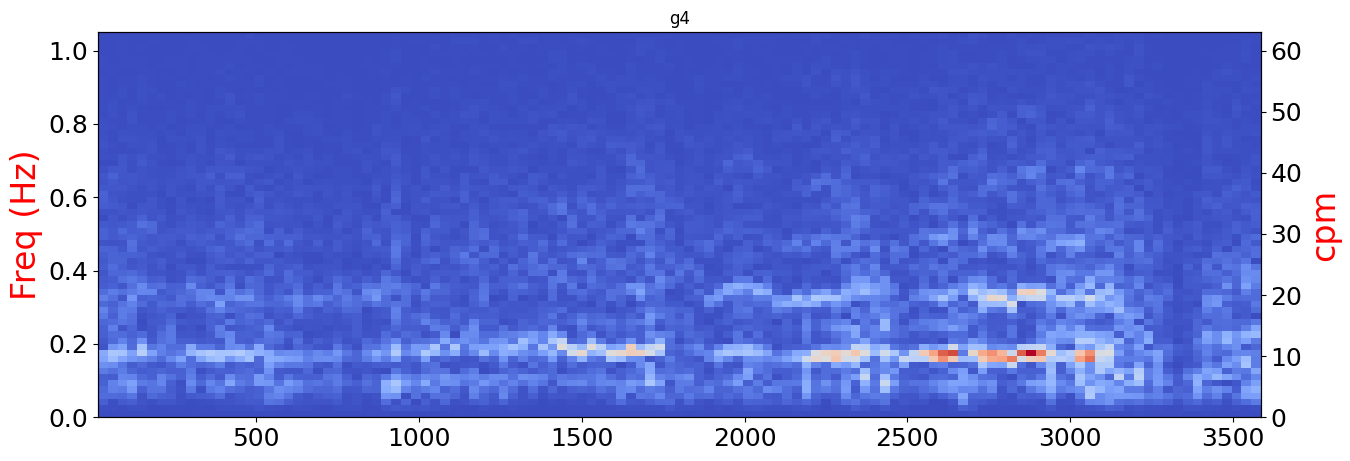

#########################################################

In [17]:
for x in df_name_lst:
    
    print(x)

    df_x = locals()[x]
    
    for y in chan_to_keep[1:]:
        Plotting.spect(arr=df_x[y], sample_freq=new_sample_freq, y_max_freq=1.5*hi_cutoff, plot_title=y)
        
    print('#########################################################')
    print()

# make summary table

In [18]:
# use deep = true to make sure that original will not be changed when modifying copy
df_copy = df_summary.copy(deep=True)

# add columns
df_copy['packet_remove_pct'] = df_packet_drop['removed_pct'].values
df_copy['art_remove_pct'] = df_artifact_remove['removed_pct'].values
df_copy['animal'] = pd.Series(animal, index=df_copy.index)
df_copy['new_sample_freq'] = pd.Series(new_sample_freq, index=df_copy.index)
df_copy['filter_type'] = pd.Series(filter_type, index=df_copy.index)
df_copy['lo_cutoff'] = pd.Series(lo_cutoff, index=df_copy.index)
df_copy['hi_cutoff'] = pd.Series(hi_cutoff, index=df_copy.index)
df_copy['remove_drop_packs'] = pd.Series(use_dropped_packet_removal, index=df_copy.index)
df_copy['remove_artifact'] = pd.Series(use_artifact_removal, index=df_copy.index)

# reorder columns
df_copy = df_copy[['animal', 'cond', 'chan', 'new_sample_freq', 'filter_type', 'lo_cutoff', 'hi_cutoff', 
                   'remove_drop_packs', 'remove_artifact', 'tot_power', 'brad_power', 
                   'norm_power', 'tach_power', 'brad_domf', 'norm_domf', 'tach_domf', 'packet_remove_pct', 'art_remove_pct']]

# replace characters
df_copy['cond'] = df_copy.cond.str.replace('df_', '')

print(df_copy)

# Write to file
results_file = 'summary.csv'

# make a results file
if not os.path.exists(results_file):
    os.mknod(results_file)
    df_copy.to_csv(results_file)  
elif os.path.exists(results_file):
    df_copy.to_csv(results_file, mode='a', header=False)

animal  cond chan  new_sample_freq filter_type  lo_cutoff  hi_cutoff  \
0  103-21  feed   g1              200    bandpass       0.05        0.7   
0  103-21  feed   g2              200    bandpass       0.05        0.7   
0  103-21  feed   g3              200    bandpass       0.05        0.7   
0  103-21  feed   g4              200    bandpass       0.05        0.7   
0  103-21  base   g1              200    bandpass       0.05        0.7   
0  103-21  base   g2              200    bandpass       0.05        0.7   
0  103-21  base   g3              200    bandpass       0.05        0.7   
0  103-21  base   g4              200    bandpass       0.05        0.7   

   remove_drop_packs  remove_artifact     tot_power    brad_power  \
0               True             True  5.683859e+08  3.482522e+08   
0               True             True  1.977780e+08  4.593116e+07   
0               True             True  1.438503e+08  4.826492e+07   
0               True             True  7.356629e+07  1.826682e+07   
0               True             True  2.033987e+08  1.106022e+08   
0               True             True  1.471267e+08  2.102337e+07   
0               True             True  6.396546e+07  1.719977e+07   
0               True             True  4.888021e+07  1.094312e+07   

     norm_power    tach_power  brad_domf  norm_domf  tach_domf  \
0  1.507273e+08  6.940649e+07     0.0561     0.1633     0.1961   
0  1.307959e+08  2.105099e+07     0.0889     0.1617     0.1911   
0  7.825107e+07  1.733433e+07     0.0617     0.1622     0.2022   
0  5.077292e+07  4.526552e+06     0.0917     0.1611     0.2389   
0  6.814714e+07  2.464939e+07     0.0767     0.1606     0.1928   
0  9.205423e+07  3.404911e+07     0.0878     0.1750     0.1933   
0  3.509980e+07  1.166588e+07     0.0656     0.1628     0.1928   
0  3.275021e+07  5.186888e+06     0.0828     0.1733     0.1928   

   packet_remove_pct  art_remove_pct  
0                0.0            4.54  
0                0.0            0.02  
0                0.0            0.12  
0                0.0            0.00  
0                0.0            1.44  
0                0.0            0.02  
0                0.0            0.03  
0                0.0            0.00

# make filtered files

In [19]:
if not os.path.exists('final_filt_data'):
    os.mkdir('final_filt_data')
    
for x in df_name_lst:

    df_x = locals()[x]    
    
    # make csv
    df_x.to_csv('final_filt_data/' + animal + '_' + x + '.csv', index=False)
    
    # make pickle
    f = open('final_filt_data/' + animal + '_' + x + '.pckl', 'wb')
    pickle.dump(df_x, f)
    f.close()